In [1]:
import cv2
import os
import shutil
import numpy as np
from tqdm import tqdm
import yaml

In [2]:
# classes didicated to instance segmentation
native_ids = {
    'person': 24,
    'rider': 25,
    'car': 26,
    'truck': 27,
    'bus': 28,
    'caravan': 29,
    'trailer': 30,
    'train': 31,
    'motorcycle': 32,
    'bicycle': 33,
}
yolo_train_ids = {
    'person': 0,
    'rider': 1,
    'car': 2,
    'truck': 3,
    'bus': 4,
    'caravan': 5,
    'trailer': 6,
    'train': 7,
    'motorcycle': 8,
    'bicycle': 9,
}

# Reverse mapping for easy lookup
native_to_yolo = {v: yolo_train_ids[k] for k, v in native_ids.items()}
print('yolo_train_ids', yolo_train_ids)
print('native_to_yolo', native_to_yolo)

yolo_train_ids {'person': 0, 'rider': 1, 'car': 2, 'truck': 3, 'bus': 4, 'caravan': 5, 'trailer': 6, 'train': 7, 'motorcycle': 8, 'bicycle': 9}
native_to_yolo {24: 0, 25: 1, 26: 2, 27: 3, 28: 4, 29: 5, 30: 6, 31: 7, 32: 8, 33: 9}


In [3]:
def extract_polygones(mask_path):
    # Read the instance mask
    instance_mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    
    # Extract unique instance IDs
    unique_instances = np.unique(instance_mask)
    
    # YOLO annotations
    H, W = instance_mask.shape
    yolo_annotations = []
    
    for instance_id in unique_instances:
        if instance_id < 1000:  # Ignore non-class pixels
            continue
        
        # Extract class ID and instance ID
        class_id = instance_id // 1000

        yolo_class_id = native_to_yolo[class_id]
    
        # Extract binary mask for the current instance
        binary_mask = (instance_mask == instance_id).astype(np.uint8) * 255
    
        # Find contours for the current instance
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
        for cnt in contours:
            if cv2.contourArea(cnt) > 200:  # Filter small areas
                polygon = []
                for point in cnt:
                    x, y = point[0]
                    polygon.append(x / W)
                    polygon.append(y / H)
                yolo_annotations.append((yolo_class_id, polygon))
    return yolo_annotations
# Paths to the dataset directories
gt_fine_dir = "/kaggle/input/cityscapes/Cityspaces/gtFine"
output_dir = "/kaggle/working/data"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)
os.makedirs(os.path.join(output_dir, "train", "labels"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "val", "labels"), exist_ok=True)

# Loop through train, val, and test splits
splits = ['train', 'val']
for split in splits:
    split_dir = os.path.join(gt_fine_dir, split)
    print(f"Processing {split} split...")

    # Count the total number of files for the progress bar
    total_files = sum(
        1 for city in os.listdir(split_dir) 
        for file in os.listdir(os.path.join(split_dir, city)) 
        if file.endswith('_gtFine_instanceIds.png')  # Use instance IDs file
    )
    
    with tqdm(total=total_files, desc=f"{split} split") as pbar:
        for city in os.listdir(split_dir):
            city_dir = os.path.join(split_dir, city)
            for file in os.listdir(city_dir):
                if file.endswith('_gtFine_instanceIds.png'):

                    # Input mask path
                    mask_path = os.path.join(city_dir, file)

                    yolo_annotations = extract_polygones(mask_path)
                    # Save YOLO annotation file
                    if yolo_annotations:
                        yolo_file = file.replace('_gtFine_instanceIds.png', '.txt')
                        yolo_path = os.path.join(output_dir, split, "labels")
                        os.makedirs(yolo_path, exist_ok=True)

                        with open(os.path.join(yolo_path, yolo_file), 'w') as f:
                            for yolo_class_id, polygon in yolo_annotations:
                                f.write(f"{yolo_class_id} ")
                                f.write(" ".join(map(str, polygon)))
                                f.write("\n")
                    pbar.update(1)


Processing train split...


train split: 100%|██████████| 2975/2975 [04:55<00:00, 10.07it/s]


Processing val split...


val split: 100%|██████████| 500/500 [00:53<00:00,  9.43it/s]


In [4]:
import os
import shutil
from tqdm import tqdm

# Source and destination directories
source_dir = "/kaggle/input/cityscapes/Cityspaces/images"
destination_dir = "/kaggle/working/data"

# Ensure destination directories exist
os.makedirs(os.path.join(destination_dir, "train", "images"), exist_ok=True)
os.makedirs(os.path.join(destination_dir, "val", "images"), exist_ok=True)

# Loop through train and val splits
splits = ['train', 'val']
for split in splits:
    source_split_dir = os.path.join(source_dir, split)
    destination_split_dir = os.path.join(destination_dir, split, "images")

    # Collect all image paths for progress tracking
    all_images = [
        os.path.join(source_split_dir, city, file)
        for city in os.listdir(source_split_dir)
        if os.path.isdir(os.path.join(source_split_dir, city))  # Ensure it's a city folder
        for file in os.listdir(os.path.join(source_split_dir, city))
        if file.endswith('.png') or file.endswith('.jpg')
    ]

    # Copy images directly to the destination
    with tqdm(total=len(all_images), desc=f"Copying {split} images") as pbar:
        for image_path in all_images:
            file_name = os.path.basename(image_path)
            # Replace '_leftImg8bit.png' with '.png'
            new_file_name = file_name.replace('_leftImg8bit.png', '.png')
            destination_path = os.path.join(destination_split_dir, new_file_name)

            shutil.copy(image_path, destination_path)
            pbar.update(1)

print("Images copied successfully.")


Copying val images: 100%|██████████| 500/500 [00:15<00:00, 33.23it/s]

Images copied successfully.


In [5]:
# Create the dataset YAML file
yaml_content = f"""train: /kaggle/working/data/train
val: /kaggle/working/data/val

nc: {len(yolo_train_ids)}
names: {list(yolo_train_ids.keys())}
"""

yaml_path = '/kaggle/working/dataset.yaml'
with open(yaml_path, 'w') as yaml_file:
    yaml_file.write(yaml_content)

print(f"Dataset conversion completed. YAML file saved to {yaml_path}")

Dataset conversion completed. YAML file saved to /kaggle/working/dataset.yaml


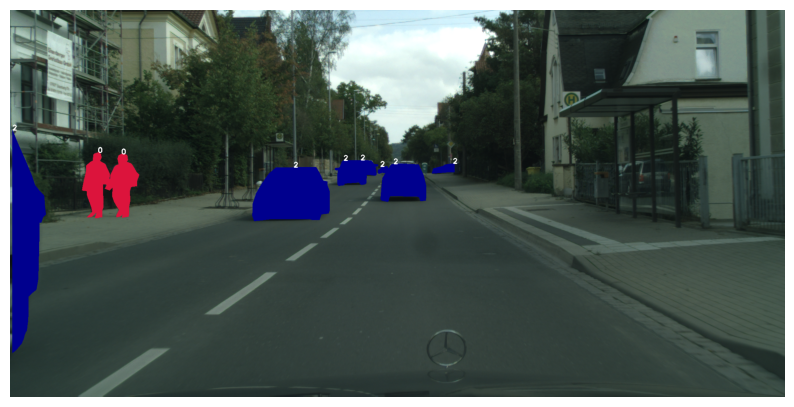

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the colors for each class
COLORS = {
    0: (220, 20, 60), 
    1: (255, 0, 0),  
    2: (0, 0, 142),    
    3: (0, 0, 70), 
    4: (0, 60, 100), 
    5: (0, 0, 90), 
    6: (0, 0, 110),
    7: (0, 80, 100),
    8: (0, 0, 230),
    9: (119, 11, 32),
}

def draw_colored_polygons(image_path, label_path, output_path=None):
    """
    Draws the polygons described in the YOLO-style label file on the image with specified colors.

    Args:
        image_path (str): Path to the image file.
        label_path (str): Path to the YOLO-style label file.
        output_path (str, optional): Path to save the output image with drawn polygons.
    """
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Read the label file
    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        points = list(map(float, parts[1:]))
        polygon = [(int(points[i] * image.shape[1]), int(points[i + 1] * image.shape[0])) for i in range(0, len(points), 2)]

        # Get the color for the current class ID
        color = COLORS.get(class_id, (0, 255, 0))  # Default to green if not found

        # Draw the filled polygon
        if len(polygon) > 2:
            cv2.fillPoly(image, [np.array(polygon, np.int32)], color=color)

        # Add class name as text
        class_name = [key for key, value in yolo_train_ids.items() if value == class_id]
        class_name = class_name[0] if class_name else f"Unknown({class_id})"
        if polygon:
            cv2.putText(image, str(class_id), polygon[0], cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    # Show the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Save the image with polygons
    if output_path:
        cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

# Example Usage
image_path = r"/kaggle/working/data/train/images/jena_000000_000019.png"
label_path = r"/kaggle/working/data/train/labels/jena_000000_000019.txt"
draw_colored_polygons(image_path=image_path, label_path=label_path, output_path=None)

In [7]:
!pip install ultralytics
!pip install wandb --upgrade
import wandb
wandb.login(key='59f43b1aad54e12d1b7b5daaf2157c74904c5acd')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.8/906.8 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 83.7 MB/s eta 0:00:00
  Attempting uninstall: wandb
    Found existing installation: wandb 0.19.1
    Uninstalling wandb-0.19.1:
      Successfully uninstalled wandb-0.19.1


wandb: Currently logged in as: elkholtihm4 (elkholtihm4-uae). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [8]:
from ultralytics import YOLO
model = YOLO("yolov8n-seg.pt")
model.train(data="/kaggle/working/dataset.yaml", epochs=100, imgsz=640, device=0, project=None)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.74M/6.74M [00:00<00:00, 124MB/s]


Ultralytics 8.3.59 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/kaggle/working/dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf

100%|██████████| 755k/755k [00:00<00:00, 23.6MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 105MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/data/train/labels... 2963 images, 12 backgrounds, 0 corrupt: 100%|██████████| 2975/2975 [00:14<00:00, 205.64it/s]


train: New cache created: /kaggle/working/data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/data/val/labels... 492 images, 8 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:06<00:00, 76.07it/s]


val: New cache created: /kaggle/working/data/val/labels.cache
Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.54G      1.481      2.805       2.04      1.019        534        640: 100%|██████████| 186/186 [04:01<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.03it/s]


                   all        500      10202      0.446      0.183      0.163      0.092      0.446      0.155      0.141     0.0688

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.57G      1.377      2.671      1.195      1.005        611        640: 100%|██████████| 186/186 [04:00<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


                   all        500      10202      0.384      0.218      0.189      0.106      0.366      0.192      0.162     0.0799

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.32G      1.367      2.639      1.135      1.004        408        640: 100%|██████████| 186/186 [04:01<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


                   all        500      10202      0.461      0.204        0.2      0.114      0.433      0.187      0.172     0.0883

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.21G      1.341       2.57      1.064     0.9991        444        640: 100%|██████████| 186/186 [04:01<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.01s/it]


                   all        500      10202      0.421      0.232      0.214      0.121       0.41      0.205      0.184     0.0939

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.62G      1.325      2.553       1.02     0.9961        363        640: 100%|██████████| 186/186 [04:02<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


                   all        500      10202      0.447      0.222      0.219      0.125      0.426      0.201      0.192     0.0956

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100       3.7G      1.314      2.533     0.9904     0.9928        384        640: 100%|██████████| 186/186 [04:02<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


                   all        500      10202      0.478      0.223      0.235      0.133       0.45        0.2      0.199      0.102

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100       3.6G      1.302      2.497     0.9605     0.9897        488        640: 100%|██████████| 186/186 [04:00<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.04it/s]


                   all        500      10202      0.453      0.252      0.237      0.132       0.46      0.218      0.207      0.102

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.82G      1.289      2.482     0.9433     0.9886        569        640: 100%|██████████| 186/186 [04:01<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


                   all        500      10202      0.462      0.242      0.242      0.136      0.431      0.218      0.208      0.106

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100       3.7G      1.284      2.464     0.9252     0.9831        418        640: 100%|██████████| 186/186 [04:04<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


                   all        500      10202      0.352       0.24      0.248      0.141      0.328      0.221      0.219      0.108

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.41G      1.265      2.418     0.8958     0.9792        330        640: 100%|██████████| 186/186 [04:01<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.03it/s]


                   all        500      10202      0.474      0.265      0.251       0.14      0.447      0.236      0.218      0.107

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.53G       1.27      2.441     0.8954     0.9805        347        640: 100%|██████████| 186/186 [04:01<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


                   all        500      10202       0.48       0.24       0.25      0.141      0.459      0.212      0.218      0.109

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.55G      1.249      2.413     0.8738     0.9705        466        640: 100%|██████████| 186/186 [04:03<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.00it/s]


                   all        500      10202      0.591      0.254      0.259      0.148      0.582      0.229      0.226      0.117

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.57G      1.247        2.4      0.866     0.9727        463        640: 100%|██████████| 186/186 [03:59<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


                   all        500      10202      0.368      0.262      0.264      0.151      0.603      0.215       0.23      0.117

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.66G      1.244      2.392     0.8532     0.9697        451        640: 100%|██████████| 186/186 [04:02<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:14<00:00,  1.11it/s]


                   all        500      10202      0.505      0.264      0.258      0.148      0.515      0.237      0.226       0.11

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.24G      1.239      2.387     0.8541     0.9709        487        640: 100%|██████████| 186/186 [04:03<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


                   all        500      10202      0.484      0.264      0.264       0.15      0.579       0.23      0.235      0.119

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.55G      1.232      2.365     0.8485     0.9675        406        640: 100%|██████████| 186/186 [04:03<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.04it/s]


                   all        500      10202      0.351      0.272      0.266      0.151      0.329      0.254      0.239       0.12

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.49G      1.232      2.357     0.8399     0.9668        453        640: 100%|██████████| 186/186 [04:02<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:17<00:00,  1.06s/it]


                   all        500      10202       0.39      0.256      0.272      0.158      0.367      0.236      0.242      0.123

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.51G       1.21      2.328     0.8246     0.9615        502        640: 100%|██████████| 186/186 [04:04<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


                   all        500      10202       0.37      0.261      0.267      0.151      0.373       0.23      0.239      0.121

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.56G      1.223      2.356     0.8302     0.9663        581        640: 100%|██████████| 186/186 [04:03<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


                   all        500      10202      0.416       0.26      0.274      0.159      0.386      0.237       0.24      0.122

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.52G      1.217      2.337      0.828     0.9636        476        640: 100%|██████████| 186/186 [04:04<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


                   all        500      10202      0.621       0.27      0.292      0.168      0.612       0.24      0.258       0.13

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.46G      1.209      2.321     0.8176     0.9626        542        640: 100%|██████████| 186/186 [04:00<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


                   all        500      10202      0.453      0.289      0.285      0.168       0.42      0.269      0.256       0.13

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100       3.6G      1.204      2.321     0.8124     0.9604        626        640: 100%|██████████| 186/186 [04:04<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


                   all        500      10202      0.379      0.282       0.29      0.174      0.508       0.24       0.26      0.136

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100       3.7G      1.207      2.328     0.8115     0.9614        397        640: 100%|██████████| 186/186 [04:06<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.04it/s]


                   all        500      10202      0.646       0.26      0.294      0.174      0.651      0.232      0.264      0.139

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.33G       1.19      2.288     0.7933     0.9548        509        640: 100%|██████████| 186/186 [04:03<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


                   all        500      10202      0.548      0.255      0.291      0.173      0.524      0.242      0.263      0.138

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.41G      1.193      2.295     0.7938     0.9566        487        640: 100%|██████████| 186/186 [04:04<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:14<00:00,  1.11it/s]


                   all        500      10202      0.428      0.269      0.305      0.179      0.409      0.243      0.271      0.139

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100       3.4G      1.186      2.278     0.7884     0.9529        458        640: 100%|██████████| 186/186 [04:00<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


                   all        500      10202      0.385      0.285      0.289      0.169      0.619      0.245      0.257      0.133

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.67G      1.192      2.293     0.7921     0.9556        406        640: 100%|██████████| 186/186 [04:01<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


                   all        500      10202      0.497      0.272      0.291       0.17      0.493      0.245      0.259      0.132

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.25G      1.181       2.28     0.7832     0.9542        451        640: 100%|██████████| 186/186 [04:04<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.03it/s]


                   all        500      10202      0.379      0.316      0.292      0.168      0.378      0.274      0.262      0.131

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.24G      1.185      2.276     0.7867     0.9534        481        640: 100%|██████████| 186/186 [04:05<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:14<00:00,  1.11it/s]


                   all        500      10202      0.351      0.318      0.301       0.18      0.486      0.246      0.267      0.139

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.34G      1.183      2.279     0.7842     0.9538        416        640: 100%|██████████| 186/186 [04:02<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:14<00:00,  1.11it/s]


                   all        500      10202      0.445       0.27        0.3      0.174      0.436      0.246      0.271      0.138

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.98G      1.176      2.258     0.7779     0.9555        437        640: 100%|██████████| 186/186 [04:02<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


                   all        500      10202      0.552      0.267      0.304      0.178      0.542      0.241      0.273       0.14

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.38G      1.179       2.26     0.7743     0.9487        680        640: 100%|██████████| 186/186 [04:01<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.04it/s]


                   all        500      10202      0.363      0.305      0.297      0.173      0.423      0.242      0.266      0.136

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.32G      1.176      2.244     0.7722     0.9499        511        640: 100%|██████████| 186/186 [04:00<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


                   all        500      10202       0.43      0.271      0.295      0.169      0.423      0.235      0.259      0.131

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.48G      1.181      2.254     0.7715     0.9499        397        640: 100%|██████████| 186/186 [04:00<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


                   all        500      10202      0.396      0.293      0.306      0.181      0.466      0.244      0.279      0.147

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.27G      1.161      2.224     0.7659     0.9484        431        640: 100%|██████████| 186/186 [04:00<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.03s/it]


                   all        500      10202      0.444      0.273      0.303      0.179      0.434      0.252      0.273      0.142

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.86G      1.161      2.221      0.755     0.9455        525        640: 100%|██████████| 186/186 [03:59<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


                   all        500      10202      0.405      0.275      0.294      0.172      0.412      0.241      0.259      0.133

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.24G      1.158      2.227     0.7581     0.9464        457        640: 100%|██████████| 186/186 [04:06<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.19it/s]


                   all        500      10202      0.393      0.293      0.308      0.184       0.45      0.245      0.278      0.145

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.55G      1.152       2.22     0.7467     0.9434        549        640: 100%|██████████| 186/186 [04:06<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.19it/s]


                   all        500      10202      0.378       0.32       0.32      0.194      0.562      0.261      0.289      0.151

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.83G      1.165       2.24     0.7546     0.9448        618        640: 100%|██████████| 186/186 [04:03<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.00s/it]


                   all        500      10202      0.394      0.312      0.307      0.181      0.364      0.288      0.275      0.144

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.64G      1.157      2.219      0.754     0.9441        252        640: 100%|██████████| 186/186 [04:06<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


                   all        500      10202      0.382      0.335      0.312      0.187      0.357       0.31       0.28      0.146

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.58G       1.15      2.212     0.7495     0.9455        601        640: 100%|██████████| 186/186 [04:07<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


                   all        500      10202      0.407      0.325      0.322      0.195       0.38      0.304       0.29      0.154

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.92G      1.147      2.201     0.7473     0.9424        565        640: 100%|██████████| 186/186 [04:03<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


                   all        500      10202      0.488      0.329      0.335      0.203      0.439      0.317      0.295      0.156

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.61G      1.164      2.225     0.7486     0.9438        532        640: 100%|██████████| 186/186 [04:07<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.02s/it]


                   all        500      10202      0.379      0.336      0.319       0.19      0.355      0.314      0.284      0.147

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.39G      1.148      2.207     0.7408     0.9408        515        640: 100%|██████████| 186/186 [04:06<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


                   all        500      10202      0.366      0.321      0.306      0.183       0.34      0.299      0.278      0.147

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.24G      1.151        2.2      0.741     0.9428        652        640: 100%|██████████| 186/186 [04:06<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


                   all        500      10202      0.378      0.313      0.296      0.177      0.358      0.288      0.266      0.141

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.66G      1.142      2.196     0.7366       0.94        551        640: 100%|██████████| 186/186 [04:06<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:14<00:00,  1.09it/s]


                   all        500      10202      0.466      0.293      0.316      0.191      0.443      0.274      0.284      0.149

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.37G      1.131      2.166     0.7248      0.936        402        640: 100%|██████████| 186/186 [04:04<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.01s/it]


                   all        500      10202      0.399       0.32      0.304      0.178       0.44      0.247      0.271       0.14

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.51G      1.146      2.208     0.7366     0.9396        479        640: 100%|██████████| 186/186 [04:07<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.04it/s]


                   all        500      10202      0.419       0.32      0.312      0.186      0.421      0.291      0.281      0.148

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.22G      1.131      2.171     0.7223     0.9351        526        640: 100%|██████████| 186/186 [04:09<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.03it/s]


                   all        500      10202      0.443       0.31      0.315       0.19      0.416      0.286      0.281      0.149

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.81G      1.137      2.172     0.7274     0.9385        372        640: 100%|██████████| 186/186 [04:04<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


                   all        500      10202      0.445      0.301      0.309      0.184      0.424      0.276      0.275      0.146

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.53G      1.139      2.189     0.7277     0.9357        557        640: 100%|██████████| 186/186 [04:09<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.16it/s]


                   all        500      10202       0.43      0.298      0.321      0.196      0.395      0.275      0.289      0.153

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.49G      1.126      2.162     0.7222     0.9358        470        640: 100%|██████████| 186/186 [04:06<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.00it/s]


                   all        500      10202      0.433       0.32      0.325      0.194      0.407      0.294      0.286      0.151

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.57G      1.126      2.169     0.7233     0.9378        419        640: 100%|██████████| 186/186 [04:06<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


                   all        500      10202      0.485       0.29      0.314      0.189      0.454      0.266      0.277       0.15

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.27G      1.127       2.16     0.7175     0.9333        510        640: 100%|██████████| 186/186 [04:01<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


                   all        500      10202      0.418      0.339      0.318      0.191       0.39      0.314      0.284      0.152

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.25G      1.111      2.134     0.7091     0.9325        484        640: 100%|██████████| 186/186 [04:02<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


                   all        500      10202      0.481      0.331      0.332        0.2       0.45      0.307      0.297      0.159

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.27G      1.122       2.16      0.714     0.9345        493        640: 100%|██████████| 186/186 [04:03<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


                   all        500      10202      0.466      0.317      0.329      0.198      0.485      0.292      0.298       0.16

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.68G      1.121      2.142     0.7114     0.9309        574        640: 100%|██████████| 186/186 [04:06<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


                   all        500      10202      0.386      0.309      0.316      0.189      0.458      0.248      0.282      0.152

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.35G      1.124      2.145     0.7122     0.9304        562        640: 100%|██████████| 186/186 [04:05<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


                   all        500      10202      0.438      0.333      0.325      0.196      0.409       0.31      0.289      0.152

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.29G      1.121      2.155     0.7101     0.9329        351        640: 100%|██████████| 186/186 [04:05<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


                   all        500      10202      0.428       0.33       0.33      0.195      0.496      0.265      0.296      0.154

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.82G      1.117      2.142     0.7061     0.9287        501        640: 100%|██████████| 186/186 [04:05<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


                   all        500      10202      0.501      0.332      0.332      0.198      0.478      0.312      0.301      0.159

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.23G      1.107      2.127     0.6983     0.9286        472        640: 100%|██████████| 186/186 [04:04<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


                   all        500      10202      0.387      0.336       0.32      0.191      0.361      0.307      0.284      0.152

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.53G      1.118      2.143     0.7069      0.932        369        640: 100%|██████████| 186/186 [04:07<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.04it/s]


                   all        500      10202      0.376      0.355      0.324      0.195      0.351      0.328      0.295      0.157

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.66G      1.114      2.129     0.7017     0.9312        356        640: 100%|██████████| 186/186 [04:05<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


                   all        500      10202      0.399      0.329       0.32      0.191      0.371      0.302      0.288      0.153

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.23G      1.121      2.155     0.7046     0.9302        393        640: 100%|██████████| 186/186 [04:11<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.23it/s]


                   all        500      10202      0.395      0.337      0.323      0.193      0.378      0.306      0.293      0.154

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.51G      1.098      2.112     0.6933      0.928        354        640: 100%|██████████| 186/186 [04:09<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


                   all        500      10202      0.482      0.295      0.314      0.187      0.452      0.273       0.28      0.148

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.33G      1.109      2.125      0.695     0.9279        402        640: 100%|██████████| 186/186 [04:08<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


                   all        500      10202      0.431      0.321      0.319      0.193      0.411      0.295      0.289      0.155

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.75G      1.106      2.122      0.691     0.9254        374        640: 100%|██████████| 186/186 [04:07<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.03it/s]


                   all        500      10202      0.492      0.295      0.328        0.2      0.469      0.273      0.295      0.157

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.31G      1.098      2.109     0.6883     0.9259        407        640: 100%|██████████| 186/186 [04:10<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:14<00:00,  1.12it/s]


                   all        500      10202      0.501      0.288      0.323      0.194      0.467      0.266      0.293      0.155

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.58G      1.107      2.128      0.695     0.9269        399        640: 100%|██████████| 186/186 [04:06<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:14<00:00,  1.12it/s]


                   all        500      10202      0.448      0.304      0.321      0.194       0.42       0.28      0.288      0.154

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.62G      1.102      2.123     0.6929     0.9268        525        640: 100%|██████████| 186/186 [04:07<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


                   all        500      10202      0.426      0.324      0.333      0.199      0.408      0.301        0.3      0.157

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.39G      1.104      2.113     0.6876     0.9247        540        640: 100%|██████████| 186/186 [04:04<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


                   all        500      10202      0.539      0.302      0.334      0.202      0.513      0.282      0.299      0.161

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.62G      1.102      2.117      0.687     0.9234        475        640: 100%|██████████| 186/186 [04:05<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:18<00:00,  1.16s/it]


                   all        500      10202      0.412      0.322      0.323      0.194      0.373      0.295       0.29      0.152

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.37G      1.096      2.108     0.6829     0.9235        394        640: 100%|██████████| 186/186 [04:04<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.03s/it]


                   all        500      10202      0.457      0.322      0.328      0.197      0.443      0.284      0.293      0.153

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.52G      1.083      2.076      0.676     0.9229        484        640: 100%|██████████| 186/186 [04:02<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.03s/it]


                   all        500      10202      0.471      0.302      0.325      0.195      0.442      0.283      0.293      0.155

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.33G      1.086      2.086      0.679     0.9213        322        640: 100%|██████████| 186/186 [04:06<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:14<00:00,  1.09it/s]


                   all        500      10202      0.471      0.294      0.329      0.199      0.445       0.27      0.294      0.157

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.67G      1.089      2.077     0.6761     0.9241        461        640: 100%|██████████| 186/186 [04:05<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]


                   all        500      10202      0.453       0.32      0.329      0.197      0.417      0.283      0.295      0.156

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.34G      1.087      2.081     0.6762     0.9214        440        640: 100%|██████████| 186/186 [04:01<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


                   all        500      10202      0.493      0.304      0.327      0.197      0.461      0.283      0.297      0.156

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.37G       1.08      2.069     0.6753     0.9204        466        640: 100%|██████████| 186/186 [04:01<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


                   all        500      10202      0.578      0.283      0.344      0.213      0.543      0.271      0.311      0.169

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.31G      1.081      2.069     0.6701     0.9193        439        640: 100%|██████████| 186/186 [04:06<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.16it/s]


                   all        500      10202      0.465      0.324      0.333      0.203      0.437      0.302        0.3      0.159

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.64G      1.072      2.058     0.6631     0.9154        392        640: 100%|██████████| 186/186 [04:03<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.07it/s]


                   all        500      10202      0.539      0.308      0.342      0.209      0.508       0.28      0.302      0.165

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.25G      1.082      2.081      0.673     0.9211        527        640: 100%|██████████| 186/186 [04:02<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


                   all        500      10202      0.496      0.314      0.341       0.21      0.468      0.295       0.31      0.167

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.56G       1.08       2.08     0.6707     0.9179        468        640: 100%|██████████| 186/186 [04:05<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:14<00:00,  1.11it/s]


                   all        500      10202      0.511      0.282      0.324      0.197      0.487       0.26      0.291      0.153

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.31G      1.078      2.075     0.6672     0.9176        575        640: 100%|██████████| 186/186 [04:06<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.15it/s]


                   all        500      10202      0.453       0.36      0.331      0.201      0.437      0.337      0.301      0.161

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.26G      1.067      2.047     0.6613     0.9167        591        640: 100%|██████████| 186/186 [04:04<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.04it/s]


                   all        500      10202       0.46      0.335      0.327      0.198      0.452      0.295      0.296      0.158

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.42G      1.074      2.054     0.6624     0.9153        416        640: 100%|██████████| 186/186 [04:03<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.00it/s]


                   all        500      10202      0.455      0.338      0.329      0.199      0.427      0.314      0.298      0.159

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.27G      1.077      2.058     0.6637      0.916        408        640: 100%|██████████| 186/186 [04:02<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


                   all        500      10202      0.423      0.343      0.331      0.198      0.393      0.318      0.297      0.156

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.28G       1.07      2.053      0.661     0.9158        456        640: 100%|██████████| 186/186 [04:09<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.16it/s]


                   all        500      10202      0.474       0.35      0.336      0.204      0.444      0.328      0.302      0.159

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.27G      1.079      2.069     0.6647     0.9206        480        640: 100%|██████████| 186/186 [04:03<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.03s/it]


                   all        500      10202      0.454      0.342      0.342       0.21      0.428      0.319      0.312      0.165

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.34G      1.072       2.06     0.6583     0.9147        439        640: 100%|██████████| 186/186 [04:06<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.03s/it]


                   all        500      10202      0.457      0.349      0.335      0.203       0.43      0.324      0.305      0.161

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.97G      1.066      2.045     0.6549     0.9139        314        640: 100%|██████████| 186/186 [04:08<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.20it/s]


                   all        500      10202      0.438       0.35      0.331      0.199      0.405      0.323      0.294      0.158
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.38G      1.073      2.075     0.6622     0.9172        281        640: 100%|██████████| 186/186 [02:21<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


                   all        500      10202       0.44      0.309      0.316      0.189      0.411      0.288      0.285      0.149

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      3.29G       1.06      2.056     0.6486     0.9116        327        640: 100%|██████████| 186/186 [02:14<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.26it/s]


                   all        500      10202      0.458      0.317      0.323      0.194      0.428      0.296       0.29      0.152

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      3.06G      1.057      2.056      0.645     0.9104        230        640: 100%|██████████| 186/186 [02:15<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


                   all        500      10202      0.457      0.317      0.321      0.192      0.434      0.296      0.287       0.15

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      3.28G      1.054      2.053     0.6456     0.9115        230        640: 100%|██████████| 186/186 [02:14<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


                   all        500      10202      0.436      0.333      0.324      0.193      0.427      0.288      0.288      0.151

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.26G      1.055       2.05     0.6425     0.9105        266        640: 100%|██████████| 186/186 [02:14<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.21it/s]


                   all        500      10202      0.412      0.324      0.325      0.195       0.38        0.3       0.29      0.153

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.56G      1.049       2.04     0.6386     0.9081        214        640: 100%|██████████| 186/186 [02:14<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.22it/s]


                   all        500      10202      0.425      0.338      0.326      0.196      0.404      0.312      0.294      0.153

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.97G       1.05      2.034      0.637     0.9093        292        640: 100%|██████████| 186/186 [02:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.19it/s]


                   all        500      10202      0.429      0.338      0.324      0.193      0.403      0.316      0.293      0.152

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      3.34G      1.046      2.019     0.6365     0.9087        256        640: 100%|██████████| 186/186 [02:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.30it/s]


                   all        500      10202      0.407      0.335      0.325      0.196      0.412      0.304      0.293      0.154

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100      3.46G      1.043      2.036     0.6336     0.9069        288        640: 100%|██████████| 186/186 [02:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.28it/s]


                   all        500      10202      0.393      0.351      0.324      0.197      0.363       0.33      0.294      0.155

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      3.32G      1.042      2.026     0.6324      0.908        221        640: 100%|██████████| 186/186 [02:13<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.19it/s]


                   all        500      10202      0.481      0.295      0.324      0.195      0.457      0.273      0.293      0.153

100 epochs completed in 6.959 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 6.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics 8.3.59 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8n-seg summary (fused): 195 layers, 3,260,014 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


                   all        500      10202      0.574      0.285      0.344      0.214      0.539      0.272      0.311       0.17
                person        388       3114      0.684      0.423      0.497       0.27      0.618      0.392      0.443      0.197
                 rider        241        574      0.779      0.343      0.418       0.22      0.653      0.291      0.312      0.103
                   car        478       4636      0.811      0.618      0.701      0.484      0.745      0.572      0.643      0.375
                 truck         77        108      0.642      0.259      0.301      0.206      0.637      0.259      0.288      0.193
                   bus         75        147       0.66      0.331      0.394      0.296      0.645      0.327      0.367      0.269
               caravan          7          7      0.272      0.143       0.23      0.192      0.264      0.143      0.221      0.142
               trailer         13         15      0.219     0.0667   

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78f426306b00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,